# Atividade 10a - Atributos de Histograma

Esta atividade tem 2 objetivos principais: 
    
*   entender o conceito de histograma
*   extrair atrubutos da imagem baseados no histograma



Antes de começar a atividade, pode ser interessante ler o notebook *Tutorial Histograma da imagem* para entender o conceito de histograma e o uso da função ``np.histogram``. Veja que ela tem alguns parâmetros que podem ser alterados, como por exemplo, o número de bins. Consulte a documentação desta função para ver diferentes formas de utilizá-la. Veja também como é plotado o histograma usando gráfico de barras.

### Parte 0 - Criar carregador de imagens

In [308]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer, minmax_scale


In [309]:
loader[0]["img"].__class__

PIL.BmpImagePlugin.BmpImageFile

In [426]:
def get_histogram_stat(img, stat = np.mean):    
    #assert is black and white and 2d
    assert img.ndim == 2
    return stat(img)

def to_black_and_white(img, dtype = np.int16, asarray = True, normalize_range = (0,255)):
    """
    transforms the image to black and white one, with 2 channels only.
    its possible to normalize and cast, if an array is returned
    """
    if isinstance(img, PIL.BmpImagePlugin.BmpImageFile):
        arr = np.array(img.convert('L'))
    else:
        arr = img
    
    if normalize_range is None:
        arr = arr.astype(dtype)
    else:
        arr =  minmax_scale(arr, normalize_range, axis = None).astype(dtype)
        
    if asarray:
        return arr
    else:
        return Image.fromarray(arr)
        

def get_histogram_stat_vector(images, stat = np.mean, normalization_function = to_black_and_white):
    """
    allows vectorized operations on ImageLoader instance or collection of images/np.arrays
    """
    if isinstance(images, ImageLoader):
        results = images.map(lambda img: stat(normalization_function(img)))
    else:
        results = list(map(lambda img: stat(normalization_function(img)), images))
        
    return results

In [427]:
class ImageLoader():
    """
    loads images from path given a list of wildcards
    """
    def __init__(self, root_dir, wildcards = [], recursive = True):
        
        root = Path(root_dir)
        if recursive:
            paths = []
            for w in wildcards:
                paths+=list(root.rglob(w))
        else:
            paths = []
            for w in wildcards:
                paths+=list(root.glob(w))
        
        self.paths = tuple(str(i) for i in set(paths))
        return
        
    def __getitem__(self, idx):
        return {"img":Image.open(self.paths[idx]), "label":self.paths[idx]}        
    
    def map(self, function, attribute = 'img'):
        assert attribute in (None, "img","label")
        if not attribute is None:
            vals = [i[attribute] for i in self]
        else:
            vals = [i for i in self]
        
        results = list(map(function, vals))
        return results
    
    

In [428]:
loader = ImageLoader('data', ["028_FLAIR24.bmp", "041_FLAIR20.bmp", "028_FLAIR24_mask.bmp", "041_FLAIR20_mask.bmp",])

In [429]:
loader.paths

('data/041_FLAIR20_mask.bmp',
 'data/041_FLAIR20.bmp',
 'data/028_FLAIR24_mask.bmp',
 'data/028_FLAIR24.bmp')

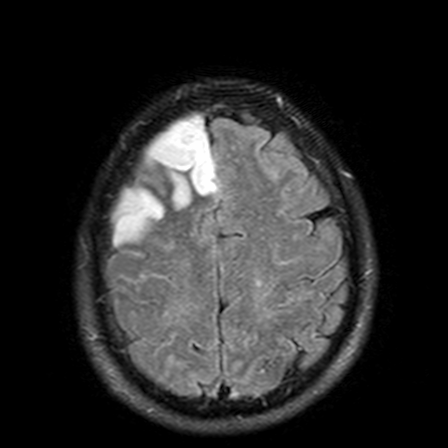

In [430]:
loader[3]["img"]

In [431]:
loader[2]

{'img': <PIL.BmpImagePlugin.BmpImageFile image mode=1 size=448x448 at 0x7FC2658B9940>,
 'label': 'data/028_FLAIR24_mask.bmp'}

### Parte 1 - Cálculo do histograma

Leia duas das imagens que serão usada no projeto P4 (*Identificação da etiologia de lesões de Lúpus*) e que estão disponibilizadas na pasta **figures**. Calcule os histogramas das imagens variando alguns parâmetros, plote e compare. 

In [432]:
i = 0
np.array(to_black_and_white(loader[i]["img"], asarray = False)).shape, np.array(loader[i]["img"]).shape

((448, 448), (448, 448, 3))

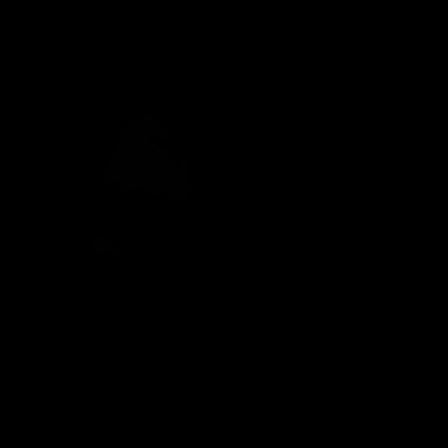

In [433]:
to_black_and_white(loader[i]["img"], asarray = False)

In [434]:
loader.map(
    lambda img: get_histogram_stat(
        to_black_and_white(img),
        stat = np.mean
    )
)

[6.44157565369898, 72.40720663265306, 6.652483258928571, 60.01234155771684]

#### Histogramas(escala log)

é possível ver os picos em 0 e 255 nas mascaras e uma distribuição mais suave nas imagens completas

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

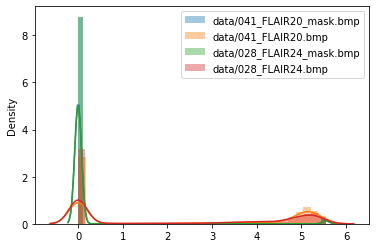

In [435]:

loader.map(lambda i: 
           sns.distplot(np.log1p(to_black_and_white(i["img"]).flatten()), label = i["label"]),
           attribute = None
          )
plt.legend()

### Parte 2 - Extração de atributos a partir do histograma

Normalmente o histograma puro não costuma ser usado como atributo, mas sim seus momentos (variância, moda, mediana, skewness, kurtosis, etc). Estes atributos podem ser extraídos usando-se funções da biblioteca Scipy. 

A partir dos 2 histogramas calculados, extraia todos os atributos dos histogramas que for possível. Tente realizar algum tipo de comparação ou discussão a respeito dos resultados.

#### Estatisticas calculadas para cada imagem:

##### Entropia
Entropia menor para mascaras, por serem apenas de duas cores, carregam menos informação

In [436]:
get_histogram_stat_vector(loader, lambda x: stats.entropy(x.flatten()))

[8.531096096585228, 11.407321323161012, 8.563313127029792, 11.264557391151294]

##### Desvio padrão

In [437]:
get_histogram_stat_vector(loader, np.std)

[40.013846288390134, 84.7923980459567, 40.64637373144694, 80.45401460182747]

##### Percentis
é possível identificar as mascaras pois seus percentis são ou 0 ou 255

In [438]:
get_histogram_stat_vector(loader, lambda x: np.percentile(x, [0, 25, 50, 75, 100]))

[array([  0.,   0.,   0.,   0., 255.]),
 array([  0.,   0.,  10., 157., 255.]),
 array([  0.,   0.,   0.,   0., 255.]),
 array([  0.,   0.,   0., 130., 255.])]

##### Assimetria

In [439]:
get_histogram_stat_vector(loader, lambda x: stats.skew(x, axis = None))

[6.050826680034785, 0.5903939212980235, 5.946287732308834, 0.9379400744358422]

##### Curtose

In [440]:
get_histogram_stat_vector(loader, lambda x: stats.kurtosis(x, axis = None))

[34.61250351182083, -1.279684387086011, 33.35833779540646, -0.6762545861405145]

##### Numero de pixels

In [441]:
get_histogram_stat_vector(loader, lambda x: len(x.flatten()), )

[200704, 200704, 200704, 200704]

### Parte 3 - Extração de atributos de uma região de interesse

Nem sempre o histograma de uma imagem e os atributo derivados dele fazem sentido em uma análise de uma região específica de interesse. Nesses casos, é preciso delimitar a região de interesse (ROI) e extrair os atributos apenas desta região.

Dada a imagem e a máscara, experimente extrair os mesmos atributos derivados do histograma apenas da região delimitada pela máscara.

In [442]:
images_arrays = loader.map(to_black_and_white)
loader.map(print, attribute = "label")
''

data/041_FLAIR20_mask.bmp
data/041_FLAIR20.bmp
data/028_FLAIR24_mask.bmp
data/028_FLAIR24.bmp


''

In [443]:
images_arrays[0].astype(bool).mean()

0.02526108099489796

In [444]:
masked_images_arrays_flattened = [
    images_arrays[1].flatten()[images_arrays[0].flatten().astype(bool)],
    images_arrays[3].flatten()[images_arrays[2].flatten().astype(bool)]
]

In [445]:
masked_images_arrays_flattened[0].astype(bool).sum()

5070

#### Histograma

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]

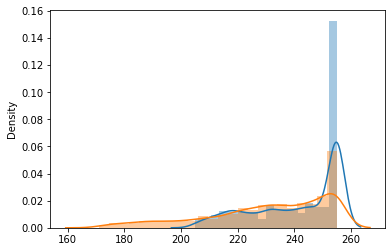

In [446]:
list(map(lambda i: sns.distplot(i), masked_images_arrays_flattened))

#### Estatisticas calculadas para cada imagem mascarada:

##### Entropia
Entropia menor para mascaras, por serem apenas de duas cores, carregam menos informação

In [448]:
get_histogram_stat_vector(masked_images_arrays_flattened, lambda x: stats.entropy(x.flatten()), normalization_function=lambda x: x)

[8.529016130731138, 8.55877489672719]

##### Desvio padrão

In [449]:
get_histogram_stat_vector(masked_images_arrays_flattened, np.std, normalization_function=lambda x: x)

[15.428430200682664, 21.633290171514695]

##### Percentis
é possível identificar as mascaras pois seus percentis são ou 0 ou 255

In [451]:
get_histogram_stat_vector(masked_images_arrays_flattened, lambda x: np.percentile(x, [0, 25, 50, 75, 100]), normalization_function=lambda x: x)

[array([205., 230., 247., 255., 255.]), array([171., 218., 234., 249., 255.])]

##### Assimetria

In [453]:
get_histogram_stat_vector(masked_images_arrays_flattened, lambda x: stats.skew(x, axis = None), normalization_function=lambda x: x)

[-0.7521145888800114, -0.8091190718915363]

##### Curtose

In [454]:
get_histogram_stat_vector(masked_images_arrays_flattened, lambda x: stats.kurtosis(x, axis = None), normalization_function=lambda x: x)

[-0.816920932961303, -0.20123492681961075]

##### Numero de pixels

In [455]:
get_histogram_stat_vector(masked_images_arrays_flattened, lambda x: len(x.flatten()), normalization_function=lambda x: x )

[5070, 5236]

### Referências

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

https://docs.scipy.org/doc/scipy/reference/stats.html

https://docs.scipy.org/doc/scipy/reference/stats.mstats.html